In [1]:
# if on colab, run this call to do install
import sys
if 'google.colab' in sys.modules:
    !git clone --quiet --recursive https://github.com/gmberton/image-matching-models.git
    %cd image-matching-models
    !pip install --progress-bar off --quiet -r requirements.txt
    !pip install --progress-bar off --quiet -e .


In [2]:
from matching import get_matcher, viz2d, available_models
from pathlib import Path
import torch
import warnings

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2
%matplotlib inline


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')
ransac_kwargs = {'ransac_reproj_thresh':3, 
                  'ransac_conf':0.95, 
                  'ransac_iters':2000} # optional ransac params
matcher = get_matcher(['sift-lg', 'aliked-lg'], device=device, **ransac_kwargs) #try an ensemble!

Using device: cuda


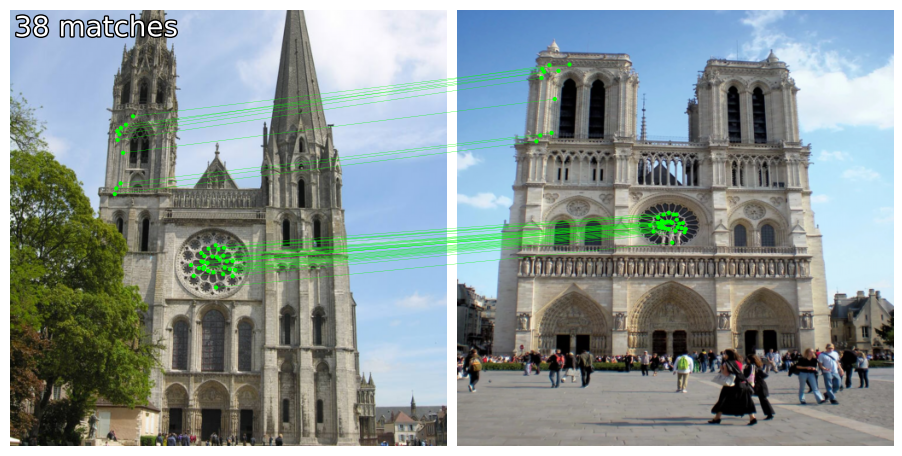

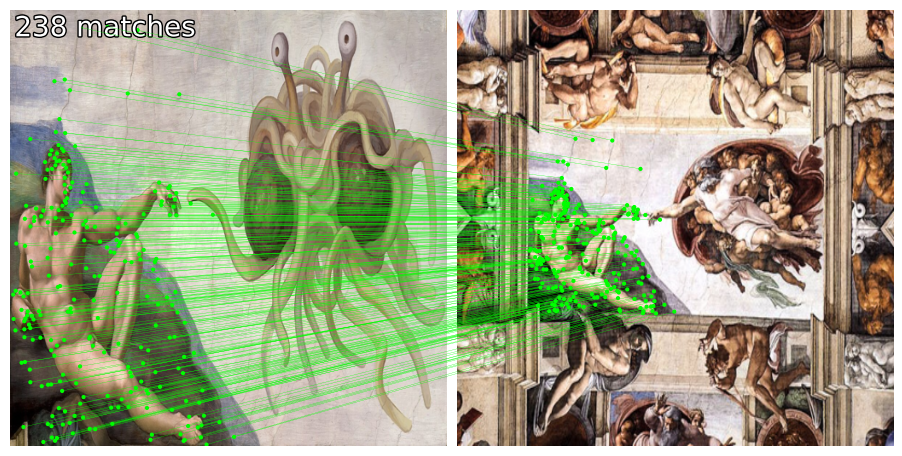

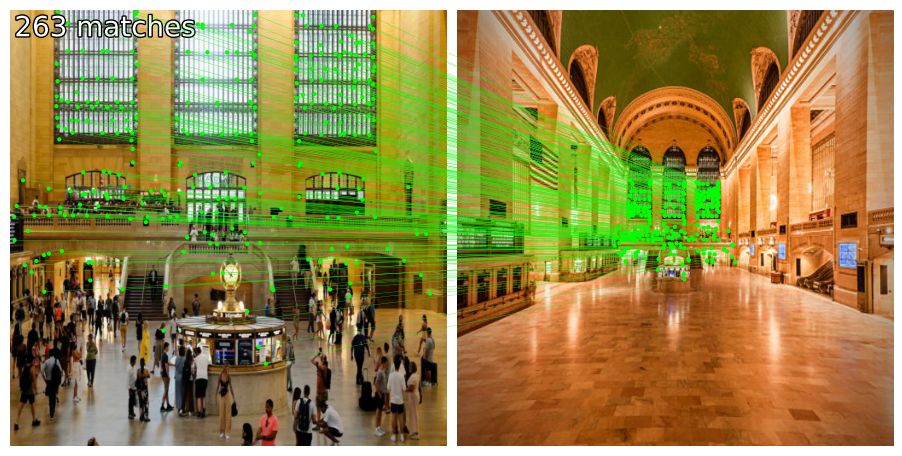

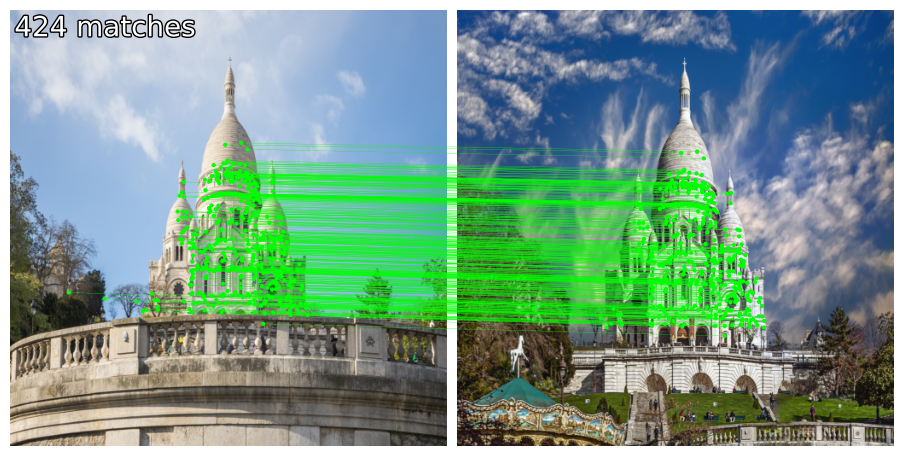

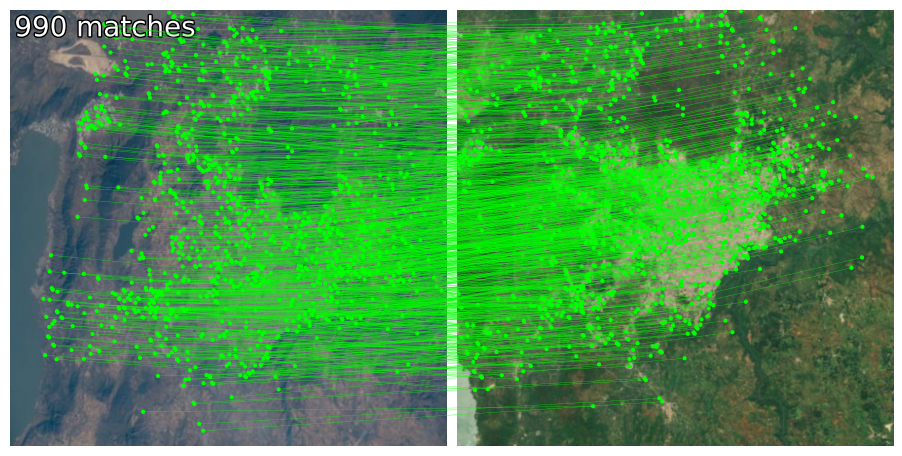

In [4]:
asset_dir = Path('assets/example_pairs')
pairs = list(asset_dir.iterdir())
image_size = 512
for pair in pairs:
    pair = list(pair.iterdir())
    img0 = matcher.load_image(pair[0], resize=image_size)
    img1 = matcher.load_image(pair[1], resize=image_size)

    result = matcher(img0, img1)
    num_inliers, H, mkpts0, mkpts1 = result['num_inliers'], result['H'], result['inlier_kpts0'], result['inlier_kpts1']

    axes = viz2d.plot_images([img0, img1])
    viz2d.plot_matches(mkpts0, mkpts1, color='lime', lw=0.2)
    viz2d.add_text(0, f'{len(mkpts1)} matches', fs=20)


### See all matchers on the same image pair

In [49]:
%%capture

image_size = 512
img0 = matcher.image_loader(pair[0], resize=image_size)
img1 = matcher.image_loader(pair[1], resize=image_size)
num_per_row = 3
fig, axs = plt.subplots(int(np.ceil(len(available_models)/num_per_row)), 2*num_per_row, figsize=(12, 20))
flat_axs = axs.flatten()

for idx, model in enumerate(available_models):
    idx = idx * 2
    ax0, ax1 = flat_axs[idx], flat_axs[idx+1]

    try:
        matcher = get_matcher(model, device=device)
        result = matcher(img0, img1)
        num_inliers, H, mkpts0, mkpts1 = result['num_inliers'], result['H'], result['inlier_kpts0'], result['inlier_kpts1']

        ax0.imshow(tensor_to_image(img0))
        ax1.imshow(tensor_to_image(img1))
        _ = viz2d.plot_matches(mkpts0, mkpts1, color='lime', lw=0.1, ps=1, axes=[ax0, ax1])
        ax0.text(image_size/2, -10, f'{model}: {len(mkpts1)} matches')

    except Exception as e:
        blank_img = np.zeros_like(tensor_to_image(img0))
        ax0.imshow(blank_img)
        ax1.imshow(blank_img)
        ax0.text(image_size/2, -10, f'{model}: Error')
        print(f'Error with {model}: {e}')
    
for ax in flat_axs:
    ax.axis('off')



Instructions for updating:
Use `tf.saved_model.load` instead.
INFO:tensorflow:Restoring parameters from c:\Users\astoken\pkgs\image-matching-models\model_weights\sp_v6\variables\variables


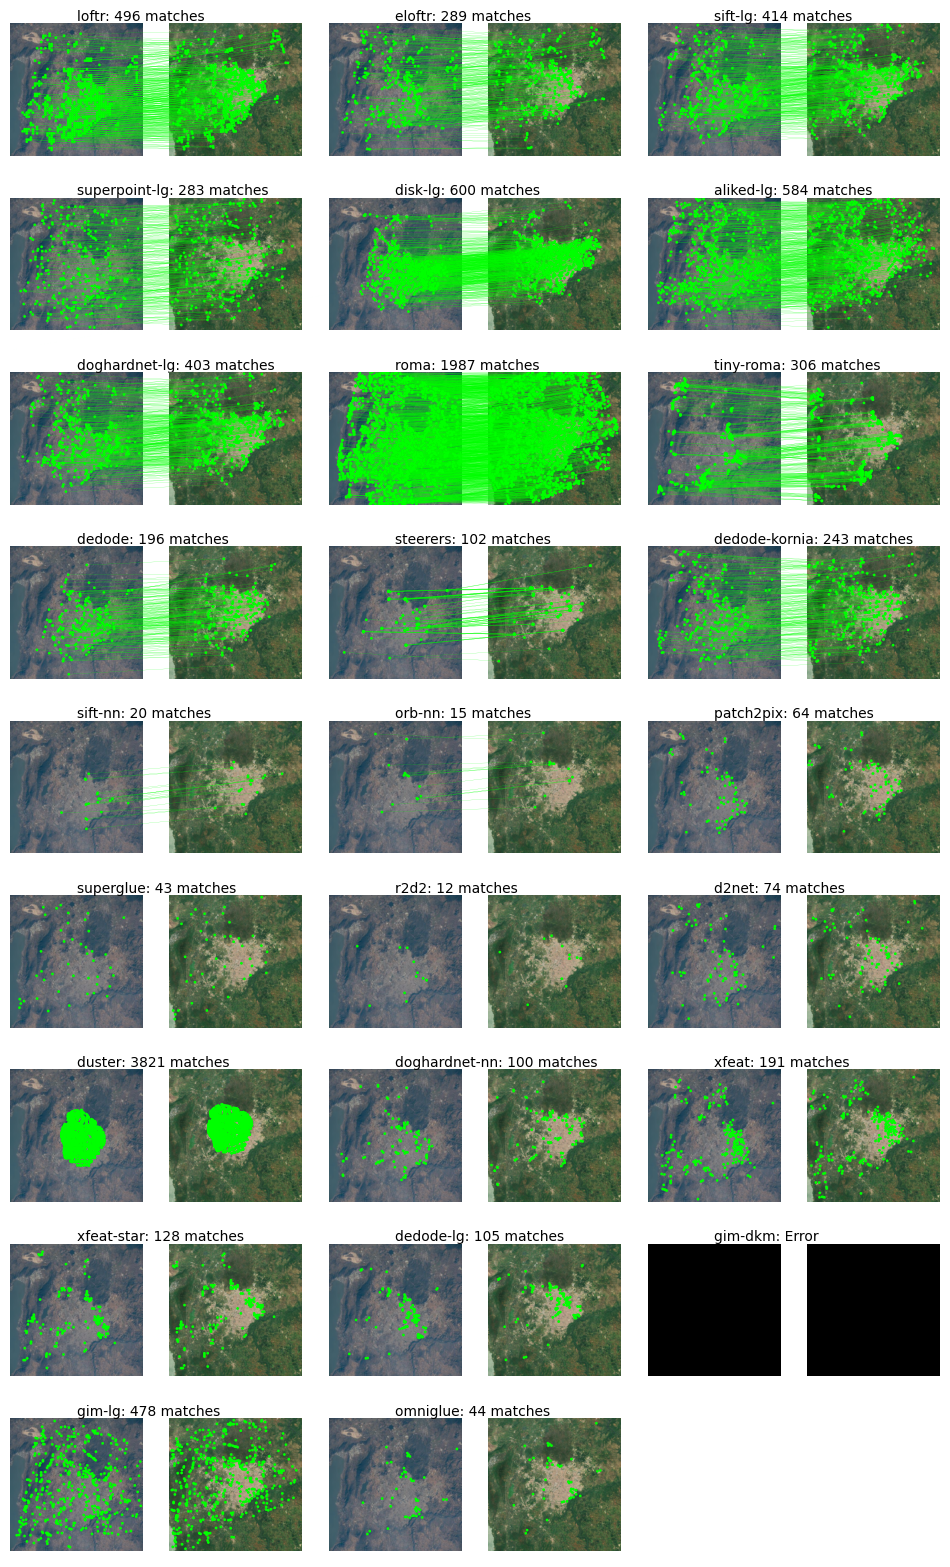

In [50]:
fig